In [38]:
import re
from pathlib import Path
from typing import Optional, Tuple, Dict, Any, Sequence

import numpy as np

import jax
import jax.lax
import jax.numpy as jnp
import optax
from flax.training.train_state import TrainState
from flax.training import checkpoints
from flax import linen as nn

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings(
    "ignore",
    message=(
        "Couldn't find sharding info under RestoreArgs.*"
    ),
    category=UserWarning,
    module="orbax.checkpoint.type_handlers"
)

data_dir = "data"
model_dir = "./models"
model_prefix = "rbm_amp_202506031229_0"

print(f"Data resides in                         : {data_dir}")
print(f"Amplitude RBM checkpoint to be loaded   : {model_dir}/{model_prefix}")

Data resides in                         : data
Amplitude RBM checkpoint to be loaded   : ./models/rbm_amp_202506031229_0


In [39]:
class MultiBasisDataLoader:
    char2id = {'Z': 0, 'X': 1, 'Y': 2}

    def __init__(self,
                 data_dict: dict[str, jnp.ndarray],
                 batch_size: int = 128,
                 shuffle: bool = True,
                 drop_last: bool = False,
                 seed: int = 0):
        # Verify all arrays have the same total length
        lengths = [v.shape[0] for v in data_dict.values()]
        if len(set(lengths)) != 1:
            raise ValueError(f"All arrays must have equal length, got: {lengths}")

        # Keep insertion order of keys (Python 3.7+ guarantees dict preserves insertion order)
        self._bases = list(data_dict.keys())          # order of basis strings
        self._arrays = list(data_dict.values())       # corresponding jnp.ndarray

        self.n_visible = data_dict[self._bases[0]].shape[1]
        self.total_samples = lengths[0]
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.rng = np.random.default_rng(seed)

        # Pre‐encode basis strings → integer arrays of shape (n_visible,)
        #   where Z→0, X→1, Y→2
        self._encoded_bases = []
        for basis_str in self._bases:
            if len(basis_str) != self.n_visible:
                raise ValueError(f"All basis strings must have length {self.n_visible}. "
                                 f"Got '{basis_str}' length {len(basis_str)}.")
            enc = np.array([MultiBasisDataLoader.char2id[c] for c in basis_str],
                           dtype=np.int8)
            self._encoded_bases.append(enc)
        # Now self._encoded_bases is a list of np.int8 arrays, each shape (n_visible,)

        # Precompute slice indices for one epoch
        self.idx_slices = [
            (i, i + batch_size)
            for i in range(0, self.total_samples, batch_size)
            if not drop_last or (i + batch_size <= self.total_samples)
        ]

    def __iter__(self):
        self._order = np.arange(self.total_samples)
        if self.shuffle:
            self.rng.shuffle(self._order)
        self._slice_idx = 0
        return self

    def __next__(self) -> Tuple[jnp.ndarray, jnp.ndarray]:
        if self._slice_idx >= len(self.idx_slices):
            raise StopIteration

        s, e = self.idx_slices[self._slice_idx]
        self._slice_idx += 1

        # Gather the correct slice for each basis‐array
        batch_arrays = []
        for arr in self._arrays:
            # arr has shape (total_samples, n_visible)
            sub = arr[self._order[s:e], :]
            batch_arrays.append(sub)   # (batch_size, n_visible)

        # Now stack:
        #   data_array: shape (N_B, batch_size, n_visible)
        data_array = jnp.stack(batch_arrays, axis=0)

        # basis_ids_array: shape (N_B, n_visible), dtype=int8
        basis_ids_array = jnp.stack(self._encoded_bases, axis=0)

        return basis_ids_array, data_array  # ready for model.apply

    def __len__(self):
        return len(self.idx_slices)


def load_measurements(folder: str, file_pattern: str = "w_*.txt") -> dict[str, jnp.ndarray]:
    out: dict[str, jnp.ndarray] = {}

    for fp in Path(folder).glob(file_pattern):
        basis = fp.stem.split("_")[2]

        bitstrings = []
        with fp.open() as f:
            for line in f:
                bitstring = np.fromiter((c.islower() for c in line.strip()), dtype=np.float32)
                bitstrings.append(bitstring)

        arr = jnp.asarray(np.stack(bitstrings))
        if basis in out:
            out[basis] = jnp.concatenate([out[basis], arr], axis=0)
        else:
            out[basis] = arr

    return out

In [40]:
data_dict = load_measurements("data/", "w_*.txt")
keys_pha = [k for k in data_dict if re.fullmatch(r"^(?!Z+$).*", k)]
dict_pha = {k: data_dict[k] for k in keys_pha}

In [41]:
class PairPhaseRBM(nn.Module):
    n_visible: int
    n_hidden: int

    def setup(self):
        zeros = lambda shape: jnp.zeros(shape, dtype=jnp.float32)
        self.W_amp = self.variable('amp', 'W_amp', zeros, (self.n_visible, self.n_hidden))
        self.b_amp = self.variable('amp', 'b_amp', zeros, (self.n_visible,))
        self.c_amp = self.variable('amp', 'c_amp', zeros, (self.n_hidden,))

        self.W_pha = self.param('W_pha', nn.initializers.normal(0.01), (self.n_visible, self.n_hidden))
        self.b_pha = self.param('b_pha', nn.initializers.zeros, (self.n_visible,))
        self.c_pha = self.param('c_pha', nn.initializers.zeros, (self.n_hidden,))

    def __call__(self, data_tuple: Tuple[jnp.ndarray, jnp.ndarray]) -> jnp.ndarray:
        basis_array, data_array = data_tuple  # (N_B, n_visible), (N_B, B, n_visible)
        loss_sums = jax.vmap(self._rotated_log_prob_loss)(data_array, basis_array)

        per_basis_mean = loss_sums / data_array.shape[1]
        return jnp.sum(per_basis_mean)

    def _free_energy_amp(self, v):
        return -(v @ self.b_amp.value) - jnp.sum(jax.nn.softplus(v @ self.W_amp.value + self.c_amp.value), -1)

    def _free_energy_pha(self, v):
        return -(v @ self.b_pha) - jnp.sum(jax.nn.softplus(v @ self.W_pha + self.c_pha), -1)

    def compute_phase(self, v: jnp.ndarray) -> jnp.ndarray:
        return -self._free_energy_pha(v)

    def _rotated_log_prob_loss(self, data: jnp.ndarray, basis_ids: jnp.ndarray) -> jnp.ndarray:
        B, n = data.shape
        non_z = jnp.nonzero(basis_ids != 0, size=2, fill_value=-1)[0]
        j, k = non_z[0], non_z[1]
        b1, b2 = basis_ids[j], basis_ids[k]

        SQRT2 = jnp.sqrt(2.0)
        rot_X = jnp.array([[1, 1], [1, -1]], dtype=jnp.complex64) / SQRT2
        rot_Y = jnp.array([[1, -1j], [1, 1j]], dtype=jnp.complex64) / SQRT2

        Rj = jax.lax.switch(b1 - 1, [lambda: rot_X, lambda: rot_Y])
        Rk = jax.lax.switch(b2 - 1, [lambda: rot_X, lambda: rot_Y])
        U = jnp.kron(Rj, Rk) # (4, 4)

        combos = jnp.array([[0.,0.],[0.,1.],[1.,0.],[1.,1.]], dtype=data.dtype)  # (4, 2)

        sigma_b_tiled = jnp.tile(data[:, None, :], (1, 4, 1))  # (B, 4, n)
        sigma_mod = sigma_b_tiled.at[:, :, [j, k]].set(combos[None, :, :])  # (B, 4, n)
        sigma_flat = sigma_mod.reshape(B * 4, n)  # (4B, n)

        F_amp = self._free_energy_amp(sigma_flat).reshape(B, 4)
        F_pha = self._free_energy_pha(sigma_flat).reshape(B, 4)

        log_mag = -0.5 * F_amp
        angle   = -0.5 * F_pha
        M = jnp.max(log_mag, axis=1, keepdims=True)
        scaled = jnp.exp(log_mag - M + 1j * angle)  # (B, 4)

        idx_in = (data[:, j].astype(int) << 1) | data[:, k].astype(int)  # (B,)
        U_cols = U[:, idx_in].T  # (B, 4)

        S_prime = jnp.sum(U_cols * scaled, axis=1)  # (B,)
        log_probs = 2.0 * (M.squeeze() + jnp.log(jnp.abs(S_prime) + 1e-12))  # (B,)

        return -jnp.sum(log_probs)

In [42]:
@jax.jit
def train_step_pha(state: TrainState, amp_vars: Dict[str, jnp.ndarray], data_tuple: Tuple[jnp.ndarray, jnp.ndarray]) -> Tuple[TrainState, jnp.ndarray]:
    loss_fn = lambda params: state.apply_fn({'params': params, 'amp': amp_vars}, data_tuple)

    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss


def train_rbm_pha(
        state:   TrainState,
        amp_vars: Dict[str, jnp.ndarray],
        loader:  "MultiBasisDataLoader",
        num_epochs: int) -> Tuple[TrainState, Dict[int, float]]:

    metrics: Dict[int, float] = {}

    for epoch in range(num_epochs):
        tot_loss  = 0.0
        n_batches = 0

        for data_tuple in loader:                       # (basis_ids, data_array)
            state, loss = train_step_pha(state, amp_vars, data_tuple)
            tot_loss  += loss
            n_batches += 1

        avg_loss = float(tot_loss / n_batches)

        metrics[epoch] = dict(
            loss=avg_loss,
        )

        print(f"Epoch {epoch+1}/{num_epochs} │ Loss_: {avg_loss:.4f}")

    return state, metrics

In [43]:
params_amp = checkpoints.restore_checkpoint(ckpt_dir=str(Path(model_dir).resolve()), target=None, prefix=model_prefix)

amp_vars = {"W_amp": params_amp["W"], "b_amp": params_amp["b"], "c_amp": params_amp["c"]}

In [44]:
batch_size    = 64
visible_units = 10
hidden_units  = 16
num_epochs    = 30
init_lr       = 1e-3

key   = jax.random.PRNGKey(0)

model_pha = PairPhaseRBM(n_visible=visible_units, n_hidden=hidden_units)

dummy_basis  = jnp.zeros((1, visible_units), dtype=jnp.int8)
dummy_data   = jnp.zeros((1, batch_size, visible_units), dtype=jnp.float32)
vars_pha = model_pha.init(key, (dummy_basis, dummy_data))

optim = optax.adam(init_lr)

state_pha = TrainState.create(apply_fn=model_pha.apply, params=vars_pha['params'], tx=optim)

loader_pha  = MultiBasisDataLoader(dict_pha, batch_size=batch_size, shuffle=True)

%time state_pha, metrics_pha = train_rbm_pha(state_pha, amp_vars, loader_pha, num_epochs)

Epoch 1/30 │ Loss_: -80.8872
Epoch 2/30 │ Loss_: -84.2034
Epoch 3/30 │ Loss_: -85.1674
Epoch 4/30 │ Loss_: -85.5544
Epoch 5/30 │ Loss_: -85.7106
Epoch 6/30 │ Loss_: -85.7803
Epoch 7/30 │ Loss_: -85.8210
Epoch 8/30 │ Loss_: -85.8524
Epoch 9/30 │ Loss_: -85.8810
Epoch 10/30 │ Loss_: -85.9088
Epoch 11/30 │ Loss_: -85.9362
Epoch 12/30 │ Loss_: -85.9629
Epoch 13/30 │ Loss_: -85.9888
Epoch 14/30 │ Loss_: -86.0140
Epoch 15/30 │ Loss_: -86.0378
Epoch 16/30 │ Loss_: -86.0603
Epoch 17/30 │ Loss_: -86.0814
Epoch 18/30 │ Loss_: -86.1005
Epoch 19/30 │ Loss_: -86.1185
Epoch 20/30 │ Loss_: -86.1348
Epoch 21/30 │ Loss_: -86.1487
Epoch 22/30 │ Loss_: -86.1615
Epoch 23/30 │ Loss_: -86.1726
Epoch 24/30 │ Loss_: -86.1819
Epoch 25/30 │ Loss_: -86.1895
Epoch 26/30 │ Loss_: -86.1957
Epoch 27/30 │ Loss_: -86.2009
Epoch 28/30 │ Loss_: -86.2046
Epoch 29/30 │ Loss_: -86.2086
Epoch 30/30 │ Loss_: -86.2106
CPU times: user 19 s, sys: 1 s, total: 20 s
Wall time: 19.1 s


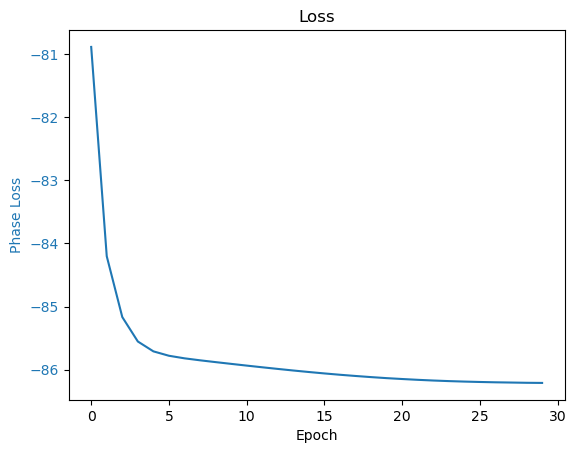

In [45]:
epochs = list(metrics_pha.keys())
loss_vals = [metrics_pha[e]['loss'] for e in epochs]

fig, ax1 = plt.subplots()

ax1.plot(epochs, loss_vals, label="Amplitude CD Loss", color="tab:blue")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Phase Loss", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

plt.title("Loss")
plt.show()

In [54]:
# Cell 1: Evaluate φ_μ(σ_k) for each one‐hot basis state, using your trained state.

import jax
import jax.numpy as jnp

# (1) Recover everything you need from training:
#    - `state_pha.params` holds the “phase” parameters (W_pha, b_pha, c_pha).
#    - `amp_vars` (that you passed into train_rbm_pha) holds the “amp” variables
#       (W_amp.value, b_amp.value, c_amp.value) under the collection name "amp".

# Suppose you still have:
#   state_pha   = <your final TrainState from train_rbm_pha>
#   amp_vars    = <the amplitude‐variables dict you passed into train_rbm_pha>

# We need to build a single `variables` dict that Flax’s `apply` will accept:
variables = {
    "params": state_pha.params,    # all the trained “phase” weights/biases
    "amp":    amp_vars,     # the trained amplitude‐variables collection
}

# (2) Build all one‐hot basis states of length = visible_units.
#     Because you set `visible_units = 10`, we will make a 10×10 identity:
visible_units = model_pha.n_visible   # should be 10 in your case
basis_states = jnp.eye(visible_units, dtype=jnp.float32)
# shape = (10, 10), where row k is [0,...,0,1,0,...,0]

# (3) Now “forward‐apply” the `compute_phase` method to each one‐hot σₖ:
#     Recall we added `compute_phase(self, v)` inside PairPhaseRBM,
#     which simply returns −self._free_energy_pha(v).
#
#     Flax requires us to call `model_pha.apply(variables, inputs…, method=…)`.
phases = model_pha.apply(variables, basis_states, method=model_pha.compute_phase)
# `phases` has shape (10,)—one φ_μ per one‐hot state.

# (4) (Optional) convert to a NumPy array for plotting later:
phases = jnp.asarray(phases) # still a JAX array; you can do `.tolist()` if you like

In [55]:
phases

Array([20.388971, 25.070332, 21.641047, 18.307957, 21.775848, 18.838604,
       14.993787, 17.067465, 14.315678, 17.015713], dtype=float32)

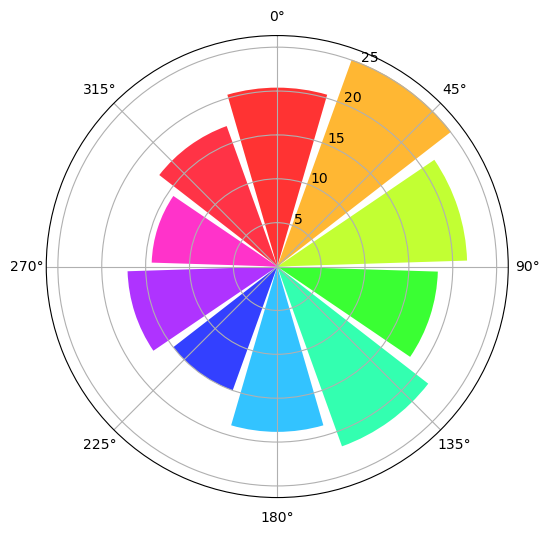

In [49]:
# Cell 2: Draw a polar‐bar chart of |φ_μ(σₖ)| for k=0,…,9

import numpy as np
import matplotlib.pyplot as plt

# Convert to a pure NumPy array for matplotlib:
phases_np = np.array(phases)            # shape = (10,)
N = phases_np.shape[0]                  # = 10

# (1) Angular position for each k: θₖ = 2π·k/N
theta = np.linspace(0.0, 2*np.pi, N, endpoint=False)

# (2) Radial coordinate = absolute value of the phase
radii = np.abs(phases_np)

# (3) Bar width = 90% of each angular segment
width = 2*np.pi / N * 0.9

# (4) Color‐map: use HSV so each bar is a different hue
cmap = plt.get_cmap("hsv")
colors = cmap(np.linspace(0, 1, N))

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection="polar")

# Draw each bar at angle θₖ, with height = |φ|, width = width
ax.bar(theta, radii, width=width, bottom=0.0, color=colors, alpha=0.8)

ax.set_theta_zero_location("N")   # put angle 0 at top
ax.set_theta_direction(-1)        # go clockwise

plt.show()

In [50]:
import numpy as np
from pathlib import Path

# load the saved state vector
data_dir = Path("data")
w_aug = np.load(data_dir / "w_aug.npy")

# find indices where the amplitude is nonzero
one_hot_idxs = np.nonzero(w_aug)[0]

# get each phase (argument) of the complex amplitude
phases = np.angle(w_aug[one_hot_idxs])

# (optional) display in binary form alongside the phase
for idx, phase in zip(one_hot_idxs, phases):
    bitstr = f"{idx:0{int(np.log2(len(w_aug)))}b}"
    print(f"{bitstr}: phase = {phase:.4f} rad")

0000000001: phase = 2.8299 rad
0000000010: phase = 0.8050 rad
0000000100: phase = -1.3442 rad
0000001000: phase = -1.5008 rad
0000010000: phase = -0.1532 rad
0000100000: phase = 0.5917 rad
0001000000: phase = -1.9015 rad
0010000000: phase = -0.8885 rad
0100000000: phase = 2.7576 rad
1000000000: phase = -1.4203 rad


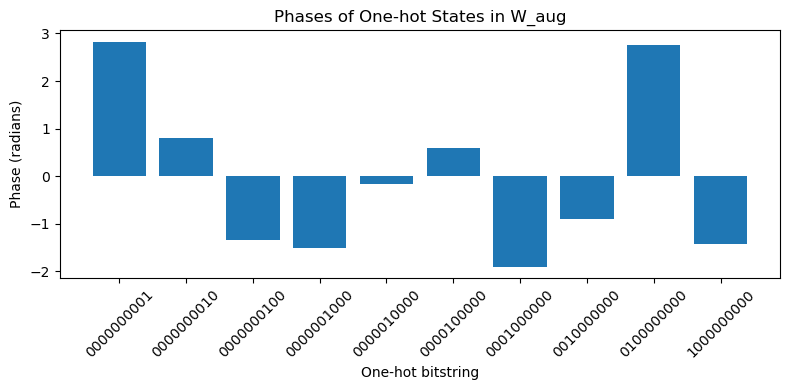

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Load the saved state vector
data_dir = Path("data")
w_aug = np.load(data_dir / "w_aug.npy")

# Determine number of qubits and find one-hot indices
num_qubits = int(np.log2(len(w_aug)))
one_hot_idxs = np.nonzero(w_aug)[0]

# Extract phases
phases = np.angle(w_aug[one_hot_idxs])

# Create bitstrings for labels
bitstrings = [f"{idx:0{num_qubits}b}" for idx in one_hot_idxs]

# Plot bar chart of phases
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(bitstrings, phases)
ax.set_xlabel("One-hot bitstring")
ax.set_ylabel("Phase (radians)")
ax.set_title("Phases of One-hot States in W_aug")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


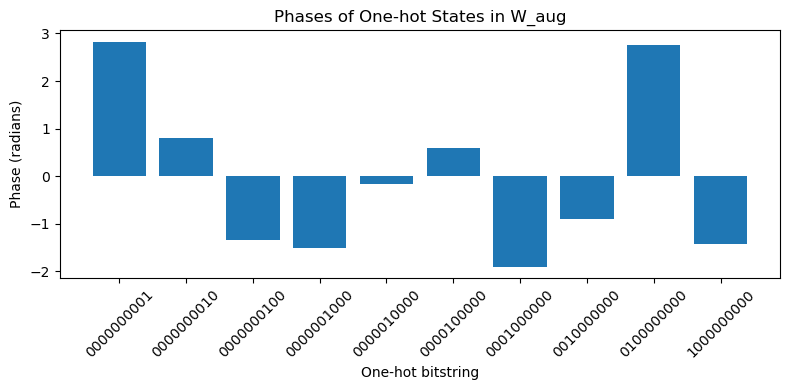

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Recreate the W-state with the same random seed for 10 qubits ----
num_qubits = 10
state_dim = 1 << num_qubits  # 2^10 = 1024

rng = np.random.default_rng(42)
thetas = rng.uniform(0, 2 * np.pi, size=num_qubits)

w_aug = np.zeros(state_dim, dtype=complex)
for j in range(num_qubits):
    idx = 1 << (num_qubits - 1 - j)
    w_aug[idx] = np.exp(1j * thetas[j]) / np.sqrt(num_qubits)

# ---- Extract one-hot indices and their phases ----
one_hot_idxs = np.nonzero(w_aug)[0]
phases = np.angle(w_aug[one_hot_idxs])  # shape = (10,)

# ---- Create bitstrings for labels ----
bitstrings = [f"{idx:0{num_qubits}b}" for idx in one_hot_idxs]

# ---- Plot bar chart of phases ----
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(bitstrings, phases, color='tab:blue')
ax.set_xlabel("One-hot bitstring")
ax.set_ylabel("Phase (radians)")
ax.set_title("Phases of One-hot States in W_aug")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


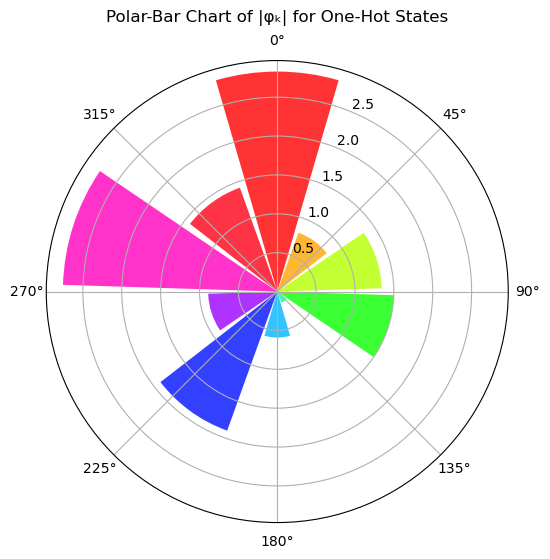

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Load the saved state vector
data_dir = Path("data")
w_aug = np.load(data_dir / "w_aug.npy")

# Determine number of qubits and find one-hot indices
num_qubits = int(np.log2(len(w_aug)))
one_hot_idxs = np.nonzero(w_aug)[0]

# Extract phases for one-hot states
phases = np.angle(w_aug[one_hot_idxs])

# Prepare for polar bar chart
N = phases.shape[0]                    # should equal num_qubits
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
radii = np.abs(phases)                 # radial coordinate = |phase|
width = 2 * np.pi / N * 0.9            # 90% of each angular segment
cmap = plt.get_cmap("hsv")
colors = cmap(np.linspace(0, 1, N))

# Plotting
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection="polar")
ax.bar(theta, radii, width=width, bottom=0.0, color=colors, alpha=0.8)
ax.set_theta_zero_location("N")   # angle 0 at top
ax.set_theta_direction(-1)        # clockwise
ax.set_title("Polar-Bar Chart of |φₖ| for One-Hot States", va='bottom')

plt.show()
